## IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

from scalecast.Forecaster import Forecaster

import statsmodels.api as sm
from datetime import datetime
import yfinance as yf
import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## DOWNLOAD DATASET FROM YAHOO FINANCE

In [2]:
def download_data(ticker):
    df = yf.download(ticker, start='2018-01-01', end='2023-12-22')
    df['Date'] = pd.to_datetime(df.index)
    return df

df = download_data('BBRI.JK')
print()
print(df.head(10).to_string())

[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close    Adj Close     Volume       Date
Date                                                                         
2018-01-01  3640.0  3640.0  3640.0  3640.0  2935.489258          0 2018-01-01
2018-01-02  3690.0  3720.0  3610.0  3630.0  2927.425293   91127100 2018-01-02
2018-01-03  3630.0  3630.0  3560.0  3610.0  2911.295898   70148700 2018-01-03
2018-01-04  3610.0  3610.0  3460.0  3550.0  2862.908691  156406300 2018-01-04
2018-01-05  3550.0  3590.0  3520.0  3590.0  2895.166992   87095600 2018-01-05
2018-01-08  3590.0  3590.0  3560.0  3590.0  2895.166992   54559100 2018-01-08
2018-01-09  3600.0  3600.0  3530.0  3570.0  2879.037598   90606700 2018-01-09
2018-01-10  3580.0  3590.0  3500.0  3530.0  2846.779541  116409100 2018-01-10
2018-01-11  3540.0  3540.0  3480.0  3540.0  2854.844238  114378900 2018-01-11
2018-01-12  3550.0  3580.0  3500.0  3540.0  2854.844238  133445300 2018-

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2018-01-01 to 2023-12-21
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       1488 non-null   float64       
 1   High       1488 non-null   float64       
 2   Low        1488 non-null   float64       
 3   Close      1488 non-null   float64       
 4   Adj Close  1488 non-null   float64       
 5   Volume     1488 non-null   int64         
 6   Date       1488 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 93.0 KB


## EXPLORATORY DATA ANALYSIS

In [4]:
df.set_index('Date', inplace=True)
df = df[['Adj Close']]

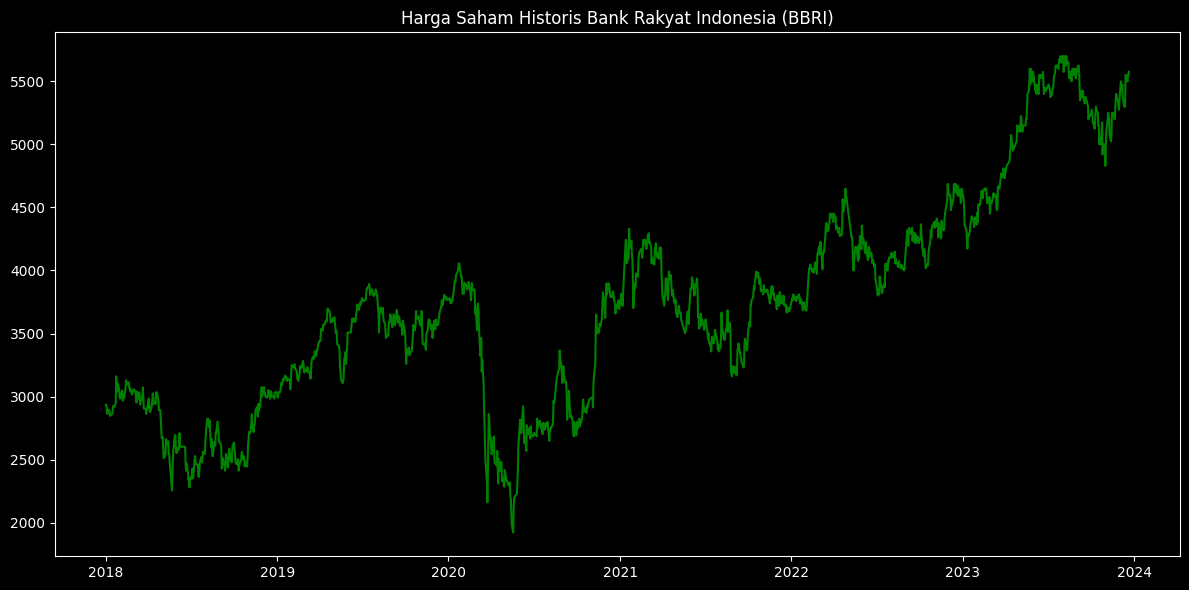

In [5]:
plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Adj Close', color='green')

plt.title('Harga Saham Historis Bank Rakyat Indonesia (BBRI)', color='white')
plt.xlabel('')
plt.ylabel('')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.grid(False)
plt.tight_layout()
plt.show()

## DATA PRE-PROCESSING

In [6]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [7]:
outliers_fraction = 0.01
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=outliers_fraction, random_state=42)

df = df.copy()
df.loc[:, 'Anomaly'] = clf.fit_predict(df_scaled)

outliers = df[df['Anomaly'] == -1]
print(outliers)

              Adj Close  Anomaly
Date                            
2020-03-24  2161.167480       -1
2020-05-12  2205.453613       -1
2020-05-13  2187.739258       -1
2020-05-14  2081.452393       -1
2020-05-15  1984.022583       -1
2020-05-18  1922.021973       -1
2020-05-19  2099.166992       -1
2020-05-20  2196.596436       -1
2023-07-28  5700.000000       -1
2023-08-01  5700.000000       -1
2023-08-02  5700.000000       -1
2023-08-03  5700.000000       -1
2023-08-07  5700.000000       -1
2023-08-09  5700.000000       -1
2023-08-10  5700.000000       -1


In [8]:
train_size = int(len(df_scaled) * 0.8)
test_size = len(df_scaled) - train_size
train, test = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]

In [9]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## MODEL TRAINING

In [10]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
min_loss_epoch = np.argmin(history.history['loss']) + 1

print(f"\nMinimum Training Loss occurred at Epoch {min_loss_epoch}: {np.min(history.history['loss'])}")
print(f"Validation Loss at Early Stopping: {history.history['val_loss'][-1]}")

Epoch 1/100

37/37 [==============================] - 10s 74ms/step - loss: 0.0296 - val_loss: 0.0110
Epoch 2/100
37/37 [==============================] - 1s 19ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 3/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/100
37/37 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 10/100
37/37 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.00

## MODEL EVALUATION

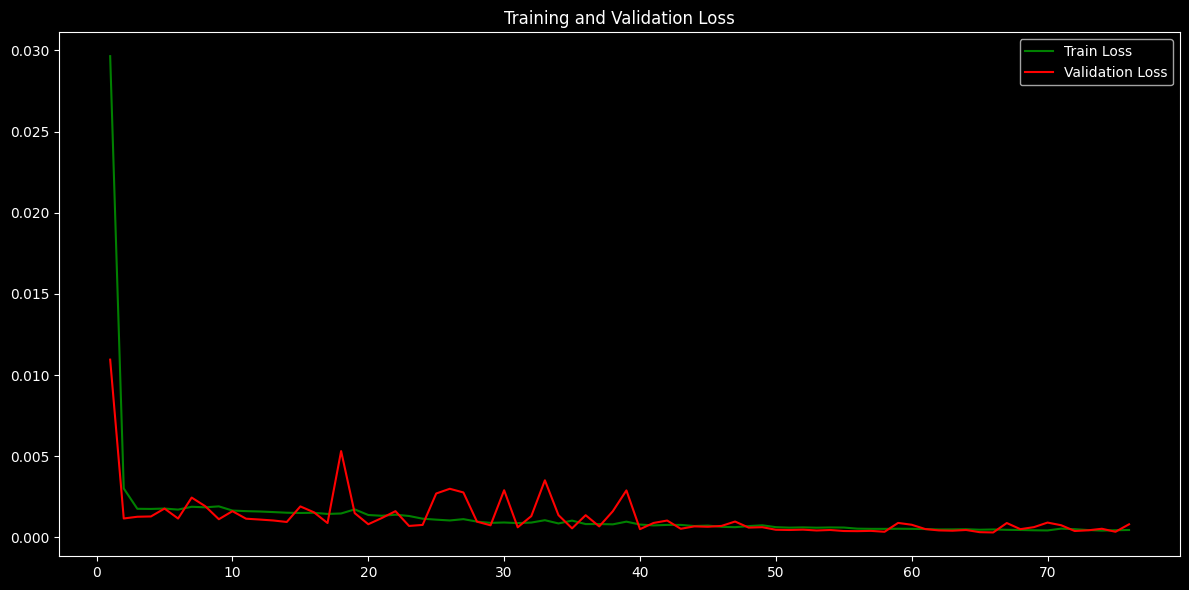

In [12]:
plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Train Loss', color='green')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='red')

plt.title('Training and Validation Loss', color='white')
plt.xlabel('')
plt.ylabel('')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

mse = mean_squared_error(y_test[0], predictions[:, 0])
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

9/9 [==============================] - 2s 8ms/step
Root Mean Squared Error: 65.663759540187


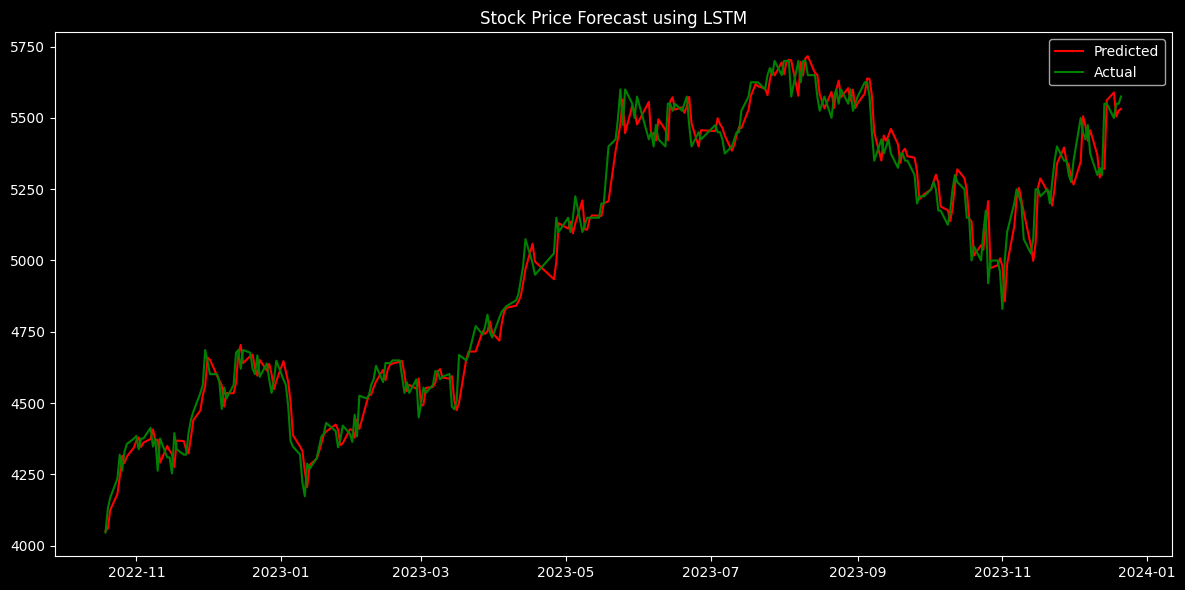

In [14]:
plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index[-len(predictions):], y=predictions[:, 0], label='Predicted', color='red')
sns.lineplot(x=df.index[-len(y_test[0]):], y=y_test[0], label='Actual', color='green')

plt.title('Stock Price Forecast using LSTM', color='white')
plt.xlabel('')
plt.ylabel('')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.show()